## Loading Libraries

In [93]:
import pandas as pd
import re

import os
import re
import csv
import codecs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,GlobalAveragePooling1D,Lambda,Bidirectional
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras.layers.embeddings import Embedding

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Extraction

In [39]:
df = pd.read_csv('C:/Users/singh/Downloads/Machine Learning Project/train.csv')
test_df = pd.read_csv('C:/Users/singh/Downloads/Machine Learning Project/test_1.csv')

In [40]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [41]:
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [42]:
df_temp =df.copy()

## Exploratory Data Analysis

In [43]:
df_temp.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [44]:
df_temp.dropna(axis = 0, inplace=True)

In [45]:
print('Total number of question pairs to train the model is :',df_temp.shape[0])

Total number of question pairs to train the model is : 404287


In [46]:
print('Total number of question pairs to test the trained model is :',test_df.shape[0])

Total number of question pairs to test the trained model is : 2345796


In [47]:
print('Number of duplicate question pairs in the training dataset are :', round(df_temp['is_duplicate'].sum()/len(df_temp), 3))

Number of duplicate question pairs in the training dataset are : 0.369


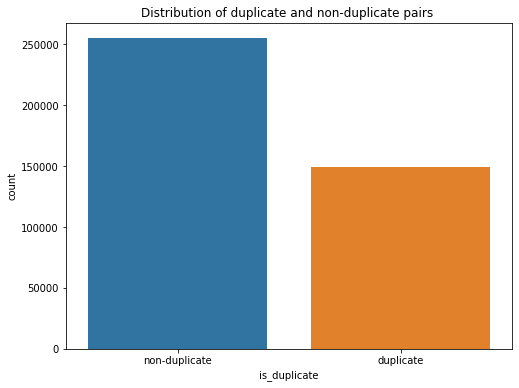

In [48]:
plt.figure(figsize=(8,6))
sns.countplot(df_temp['is_duplicate'])
plt.title('Distribution of duplicate and non-duplicate pairs ')
plt.xticks(ticks = range(2), labels = ['non-duplicate', 'duplicate'])
plt.show()

## Data Processing

In [49]:
df_temp['question1'] = df_temp['question1'].apply(lambda x: (str(x)))
df_temp['question2'] = df_temp['question2'].apply(lambda x: (str(x)))

In [50]:
stops = set(stopwords.words('english'))

SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()
    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

#    stops = set(stopwords.words("english"))
    # Clean the text, with the option to stem words.
    
    # Empty question
    
    if type(text) != str or text=='':
        return ''

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"can't", "cannot ", text)
    
    text = re.sub(r"doesn't", "does not ", text)
    text = re.sub(r"didn't", "did not ", text)
    text = re.sub(r"wouldn't", "would not ", text)
    text = re.sub(r"isn't", "is not ", text)
    
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", "  ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
    
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) # replace non-ascii word with special word
    
    # indian dollar
    
    text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)
    
    # clean text rules get from : https://www.kaggle.com/currie32/the-importance-of-cleaning-text
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text) 
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
    
    

    text = text.split()

    return text

In [51]:
#sample questions
df_temp['question1'].iloc[0:10]

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
5    Astrology: I am a Capricorn Sun Cap moon and c...
6                                  Should I buy tiago?
7                       How can I be a good geologist?
8                      When do you use シ instead of し?
9    Motorola (company): Can I hack my Charter Moto...
Name: question1, dtype: object

In [52]:
#token wise pre-processed questions
for x in  df_temp['question1'].iloc[0:20].apply(text_to_word_list):
    print(str(len(x)) + '---->'+ str(x))

14---->['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'India']
10---->['what', 'is', 'the', 'story', 'of', 'kohinoor', 'koh', 'i', 'noor', 'diamond']
14---->['how', 'can', 'i', 'increase', 'the', 'speed', 'of', 'my', 'internet', 'connection', 'while', 'using', 'a', 'vpn']
11---->['why', 'am', 'i', 'mentally', 'very', 'lonely', 'how', 'can', 'i', 'solve', 'it']
13---->['which', 'one', 'dissolve', 'in', 'water', 'quikly', 'sugar', 'salt', 'methane', 'and', 'carbon', 'di', 'oxide']
18---->['astrology', ':', 'i', 'am', 'a', 'capricorn', 'sun', 'cap', 'moon', 'and', 'cap', 'rising', 'what', 'does', 'that', 'say', 'about', 'me']
4---->['should', 'i', 'buy', 'tiago']
7---->['how', 'can', 'i', 'be', 'a', 'good', 'geologist']
6---->['when', 'do', 'you', 'use', 'instead', 'of']
10---->['motorola', 'company', ':', 'can', 'i', 'hack', 'my', 'charter', 'motorolla', 'dcx3400']
9---->['method', 'to', 'find', 'separation', 'of', 'slits', 'using', 'f

In [53]:
#tokenizing each question
tokenizer = Tokenizer(num_words=200000)
tokenizer.fit_on_texts(df_temp['question1'] + df_temp['question2'])

In [62]:
filename = 'tokenization.pkl'
pickle.dump(tokenizer, open(filename, 'wb'))

In [64]:
word_index = tokenizer.word_index
print('Total number of words identified from tokenization process are:',len(word_index))

Total number of words identified from tokenization process are: 96492


In [65]:
#converting questions to tokenized sequences 
question1_word_sequences = tokenizer.texts_to_sequences(df_temp['question1'])
question2_word_sequences = tokenizer.texts_to_sequences(df_temp['question2'])

In [66]:
#padding the questions to 25 words
q1_data = pad_sequences(question1_word_sequences, maxlen=25)
q2_data = pad_sequences(question2_word_sequences, maxlen=25)

In [67]:
#changing the datatype of test questions to text
test_df['question1'] = test_df['question1'].apply(lambda x: (str(x)))
test_df['question2'] = test_df['question2'].apply(lambda x: (str(x)))

## Loading Embedding Matrix 

In [68]:
embeddings_index = {}
f = open('C:/Users/singh/Downloads/glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [69]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))

for word, i in word_index.items():
    
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [85]:
filename = 'embedding_matrix.pkl'
pickle.dump(embedding_matrix, open(filename, 'wb'))

In [70]:
print('Shape of embedding matrix is', embedding_matrix.shape)

Shape of embedding matrix is (96493, 300)


In [71]:
#creating array for labels
target=df_temp['is_duplicate']

labels = np.array(target, dtype=int)

In [72]:
#split data into training set and validation set
X = np.stack((q1_data, q2_data), axis=1)
target = labels

X_train, X_val, y_train, y_val = train_test_split(X, target, test_size=0.20, random_state=1, stratify=target)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_val = X_val[:,0]
Q2_val = X_val[:,1]

In [73]:
#defining function to find similarity through vector distance 
def vec_distance(vects):
    x, y = vects
    return K.sum(K.square(x - y), axis=1, keepdims=True)

In [74]:
def vec_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

## Defining Model

In [75]:
#defining embedding layer
nb_words = embedding_matrix.shape[0]                 

max_sentence_len = 25

embedding_layer = Embedding(nb_words,300,
                            weights=[embedding_matrix],
                            input_length=max_sentence_len,
                            trainable=False)
#dont train this layer!

In [76]:
lstm_layer =LSTM(128)

sequence_1_input = Input(shape=(max_sentence_len,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

sequence_2_input = Input(shape=(max_sentence_len,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

distance=Lambda(vec_distance, output_shape=vec_output_shape)([x1, y1])

dense1 = Dense(16, activation='sigmoid')(distance)
dense1 = Dropout(0.3)(dense1)

bn2 = BatchNormalization()(dense1)

prediction=Dense(1, activation='sigmoid')(bn2)

model = Model(input=[sequence_1_input, sequence_2_input], output=prediction)

C:\Users\singh\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [77]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 25, 300)      28947900    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 128)          219648      embedding_2[0][0]          

In [78]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['acc'])

In [79]:
early_stopping =EarlyStopping(monitor='val_loss', patience=3)

In [80]:
hist=model.fit([Q1_train, Q2_train], 
               y_train, 
               validation_data=([Q1_val, Q2_val], y_val), 
               verbose=1, 
               epochs=10, 
               batch_size=256, 
               shuffle=True,
               class_weight=None, 
               callbacks=[early_stopping])

C:\Users\singh\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 323429 samples, validate on 80858 samples
Epoch 1/10
323429/323429 [==============================] - 280s 866us/step - loss: 0.5353 - acc: 0.7306 - val_loss: 0.4409 - val_acc: 0.7966
Epoch 2/10
323429/323429 [==============================] - 243s 753us/step - loss: 0.4300 - acc: 0.8026 - val_loss: 0.4107 - val_acc: 0.8111
Epoch 3/10
323429/323429 [==============================] - 263s 813us/step - loss: 0.3902 - acc: 0.8267 - val_loss: 0.3957 - val_acc: 0.8210
Epoch 4/10
323429/323429 [==============================] - 254s 784us/step - loss: 0.3618 - acc: 0.8436 - val_loss: 0.3804 - val_acc: 0.8291
Epoch 5/10
323429/323429 [==============================] - 260s 805us/step - loss: 0.3387 - acc: 0.8555 - val_loss: 0.3768 - val_acc: 0.8309
Epoch 6/10
323429/323429 [==============================] - 278s 860us/step - loss: 0.3186 - acc: 0.8658 - val_loss: 0.3899 - val_acc: 0.8343
Epoch 7/10
323429/323429 [==============================] - 278s 861us/step - loss: 0.3015 - acc:

In [81]:
model.save('trained_model_ml_similarity.h5')

In [82]:
model.load_weights('trained_model_ml_similarity.h5')

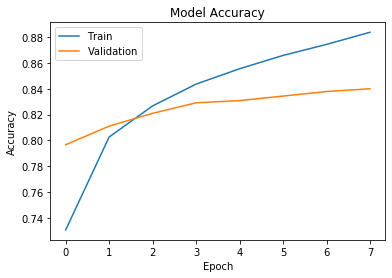

In [83]:
# Plot accuracy
import matplotlib.pyplot as plt

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

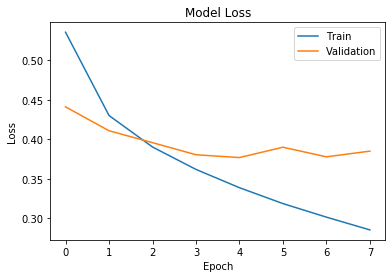

In [114]:
# Plot loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()